# Lecture 6 (Part 1) — Time Value of Money

This notebook walks through `0210Lecture 6 - part 1-time value of money.pdf` **page by page** and
adds small **Python practice** snippets to make the math operational.

## Learning goals
1. Explain why future cash flows are worth less than cash flows today.
2. Compute present value (PV) by discounting.
3. Value an **annuity** and a **growing annuity**.
4. Value a **perpetuity** and a **growing perpetuity** (Gordon Growth Model).


In [1]:
# Setup: imports + helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

def pv_single(cf: float, r: float, t: int) -> float:
    """Present value (t=0) of a cash flow received at the end of period t."""
    return cf / (1 + r) ** t

def pv_stream(cashflows, r: float) -> float:
    """cashflows: iterable of (t, cf) where t = 1,2,..."""
    return sum(pv_single(cf, r, t) for t, cf in cashflows)

def pv_annuity(A: float, r: float, n: int) -> float:
    """Ordinary annuity with payment A at t=1..n."""
    if r == 0:
        return A * n
    return A * (1 - (1 / (1 + r) ** n)) / r

def pv_growing_annuity(A0: float, r: float, g: float, n: int) -> float:
    """Growing annuity where CF_t = A0*(1+g)^t for t=1..n (matches slide notation)."""
    if r == g:
        # If r == g, each discounted term equals A0, so PV = n*A0.
        return n * A0
    return A0 * (1 + g) * (1 - ((1 + g) ** n) / ((1 + r) ** n)) / (r - g)

def pv_perpetuity(A: float, r: float) -> float:
    """Perpetuity with constant payment A starting at t=1."""
    if r <= 0:
        raise ValueError('r must be > 0 for a perpetuity.')
    return A / r

def pv_growing_perpetuity(A0: float, r: float, g: float) -> float:
    """Growing perpetuity where CF_1 = A0*(1+g), CF_t grows at g forever."""
    if r <= g:
        raise ValueError('Require r > g for a growing perpetuity.')
    return A0 * (1 + g) / (r - g)


## Page 01 — Why A Dollar Tomorrow Is Worth Less Than A Dollar Today

### Slide content (transcribed)

**Preference for current consumption increases**
- People generally prefer current consumption to future consumption, so they must be compensated
  with a larger future payoff to postpone consumption.

**Expected inflation increases**
- The purchasing power of money decreases over time due to inflation. Higher inflation increases the
  gap in real value between one dollar today and one dollar in the future.

**The uncertainty in the cash flow increases**
- If there is uncertainty about receiving future cash flows, those cash flows will be valued less.

**Conclusion:** other things remaining equal, the value of cash flows in future time periods will decrease.

<details>
<summary>Slide screenshot (PDF page 1)</summary>

![](pic/0210_lecture6_tvm/page-01.png)

</details>


In [2]:
# Mini-demo: how the present value of $1 declines as time increases
r = 0.06  # 6% discount rate
years = np.arange(0, 31)
pv_1 = 1 / (1 + r) ** years

pd.DataFrame({'Year (t)': years, 'PV of $1 received at end of year t': pv_1}).head(10)


,Year (t),PV of $1 received at end of year t
0,0,1.000000
1,1,0.943396
2,2,0.889996
3,3,0.839619
4,4,0.792094
5,5,0.747258
6,6,0.704961
7,7,0.665057
8,8,0.627412
9,9,0.591898


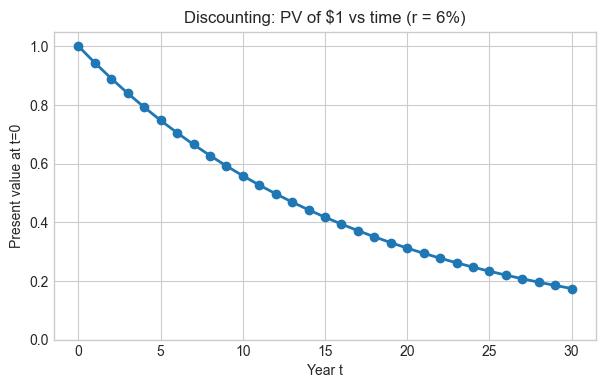

In [3]:
plt.figure(figsize=(7, 4))
plt.plot(years, pv_1, marker='o', linewidth=2)
plt.title('Discounting: PV of $1 vs time (r = 6%)')
plt.xlabel('Year t')
plt.ylabel('Present value at t=0')
plt.ylim(0, 1.05)
plt.show()


## Page 02 — Discounting

### Slide content (transcribed)

A **timeline** is used to organize cash flows occurring at different points in time by showing both the timing
and the amount of each cash flow.

**Discounting** is the process of converting future cash flows into their **present value**.
**Present value** measures the value today of a future cash flow.

**Present value of a single cash flow**

$$
PV = \frac{CF_t}{(1+r)^t}
$$

where $CF_t$ is the cash flow received at the end of period $t$, and $r$ is the discount rate.

**Present value of an asset with multiple cash flows** equals the sum of the present values of all future cash flows:

$$
PV = \sum_{t=1}^{n} \frac{CF_t}{(1+r)^t}
$$

**Example:** How to calculate the present value of an asset that pays **$100 at the end of each of the next four years**.
- Step 1: Draw a timeline showing all cash flows.
- Step 2: Calculate the present value of the cash flow in each year.
- Step 3: Add all present values to obtain the total present value.

<details>
<summary>Slide screenshot (PDF page 2)</summary>

![](pic/0210_lecture6_tvm/page-02.png)

</details>


In [4]:
# Example (from the slide): $100 paid at the end of each of the next 4 years
r = 0.06
cashflows = [(t, 100.0) for t in range(1, 5)]

rows = []
for t, cf in cashflows:
    rows.append(
        {
            'Year (t)': t,
            'Cash flow ($)': cf,
            'Discount factor': 1 / (1 + r) ** t,
            'Present value ($)': pv_single(cf, r, t),
        }
    )

df = pd.DataFrame(rows)
df.loc['Total'] = ['', df['Cash flow ($)'].sum(), '', df['Present value ($)'].sum()]
df


,Year (t),Cash flow ($),Discount factor,Present value ($)
0,1,100.0,0.943396,94.339623
1,2,100.0,0.889996,88.999644
2,3,100.0,0.839619,83.961928
3,4,100.0,0.792094,79.209366
Total,,400.0,,346.510561


In [5]:
# Cross-check: this cash-flow stream is an ordinary annuity with A=100, n=4
pv_sum = pv_stream(cashflows, r)
pv_formula = pv_annuity(A=100.0, r=r, n=4)
pd.DataFrame(
    {
        'Method': ['Sum of discounted cash flows', 'Annuity closed-form'],
        'PV ($)': [pv_sum, pv_formula],
    }
)


,Method,PV ($)
0,Sum of discounted cash flows,346.510561
1,Annuity closed-form,346.510561


## Page 03 — Estimating the PV of Annuity

### Slide content (transcribed)

An **annuity** is a constant cash flow that occurs at regular intervals for a fixed period of time.

**Present value of an ordinary annuity** (payment $A$ at the end of each period, for $n$ periods):

$$
PV(A,r,n) = A\left[\frac{1 - \frac{1}{(1+r)^n}}{r}\right]
$$

A **growing annuity** is a cash flow growing at a constant rate $g$ for a specified period of time.

**Present value of a growing annuity** (slide notation uses a base level $A$ so that $CF_1 = A(1+g)$):

$$
PV = A(1+g)\left[\frac{1 - \frac{(1+g)^n}{(1+r)^n}}{r-g}\right]
$$

**Example (corporate borrowing):** valuing a corporate bank loan using an annuity model.
- Annual payment (end of year): $1.2$ billion
- Required rate of return (discount rate): 6%
- 5-year amortizing bank loan (ordinary annuity)

<details>
<summary>Slide screenshot (PDF page 3)</summary>

![](pic/0210_lecture6_tvm/page-03.png)

</details>


In [6]:
# Example (from the slide): AT&T 5-year amortizing loan
A = 1.2  # $ billions, paid at end of each year
r = 0.06
n = 5

pv_att = pv_annuity(A=A, r=r, n=n)
pv_att


5.05483654267886

In [7]:
# Cross-check by explicit discounting
pv_att_sum = pv_stream([(t, A) for t in range(1, n + 1)], r=r)
pv_att, pv_att_sum, pv_att - pv_att_sum


(5.05483654267886, 5.054836542678856, 3.552713678800501e-15)

In [8]:
# Optional practice: a growing annuity (verify formula vs explicit sum)
A0 = 100.0   # base level so that CF_1 = A0*(1+g)
g = 0.03
r = 0.08
n = 5

pv_ga_formula = pv_growing_annuity(A0=A0, r=r, g=g, n=n)
cashflows_ga = [(t, A0 * (1 + g) ** t) for t in range(1, n + 1)]
pv_ga_sum = pv_stream(cashflows_ga, r=r)

pd.DataFrame(
    {
        'Method': ['Growing annuity closed-form', 'Sum of discounted cash flows'],
        'PV ($)': [pv_ga_formula, pv_ga_sum],
    }
)


,Method,PV ($)
0,Growing annuity closed-form,434.696141
1,Sum of discounted cash flows,434.696141


## Page 04 — Estimating the PV of Perpetuity

### Slide content (transcribed)

A **perpetuity** is a constant cash flow at regular intervals forever.

**Present value of a perpetuity** (constant payment $A$ starting at $t=1$):

$$
PV = \frac{A}{r}
$$

A **growing perpetuity** is a cash flow that is expected to grow at a constant rate forever.

**Present value of a growing perpetuity** (slide notation uses a base level $A$ so that $CF_1 = A(1+g)$):

$$
PV = \frac{A(1+g)}{r-g}
$$

Growing perpetuities are particularly useful for valuing **equity in publicly traded firms**, as such firms are
assumed to have potentially infinite lives.

**Example (Gordon Growth Model):** valuing Coca-Cola using a growing perpetuity.
- In 2023, annual dividends: $D_0 = $1.84 per share
- Expected long-term growth: $g \approx 5\%$
- Required return on equity: $r = 8\%$

$$
P_0 = \frac{D_0(1+g)}{r-g}
$$

<details>
<summary>Slide screenshot (PDF page 4)</summary>

![](pic/0210_lecture6_tvm/page-04.png)

</details>


In [9]:
# Example (from the slide): Coca-Cola (Gordon Growth Model)
D0 = 1.84
g = 0.05
r = 0.08

P0 = pv_growing_perpetuity(A0=D0, r=r, g=g)
P0


64.4

In [10]:
# Sensitivity practice: how P0 changes with (r, g)
r_grid = np.array([0.07, 0.08, 0.09, 0.10])
g_grid = np.array([0.03, 0.04, 0.05, 0.06])

table = pd.DataFrame(index=[f"g={x:.0%}" for x in g_grid], columns=[f"r={x:.0%}" for x in r_grid], dtype=float)
for gg in g_grid:
    for rr in r_grid:
        table.loc[f"g={gg:.0%}", f"r={rr:.0%}"] = np.nan if rr <= gg else pv_growing_perpetuity(D0, rr, gg)

table


,r=7%,r=8%,r=9%,r=10%
g=3%,47.380000,37.904,31.586667,27.074286
g=4%,63.786667,47.840,38.272000,31.893333
g=5%,96.600000,64.400,48.300000,38.640000
g=6%,195.040000,97.520,65.013333,48.760000


## Key takeaways

- Discounting turns future cash flows into present dollars.
- PV falls with time $t$ and rises when the discount rate $r$ is lower.
- Many valuation building blocks reduce to **sums of discounted cash flows**.
- Closed-form formulas (annuity / perpetuity / growing versions) are algebraic shortcuts for those sums.
